<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lab-4:-Function-approximation" data-toc-modified-id="Lab-4:-Function-approximation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Lab 4: Function approximation</strong></a></span></li><li><span><a href="#Abstract" data-toc-modified-id="Abstract-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Abstract</strong></a></span></li><li><span><a href="#Set-up-environment" data-toc-modified-id="Set-up-environment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>Set up environment</strong></a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><strong>Introduction</strong></a></span></li><li><span><a href="#Methods" data-toc-modified-id="Methods-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>Methods</strong></a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><strong>Results</strong></a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><strong>Discussion</strong></a></span></li></ul></div>

<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/Volkaa/Lab-4/Volkaa-lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Function approximation**
**Matthis Manthe**

# **Abstract**

In this lab, we approach the wide domain of function approximation. We implement a general framework to use the L2 projection algorithm on some function basis, and the specific functions required to use it on the basis of piecewise linear continuous functions. 

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program uses a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [6]:
# Load neccessary modules.
# from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

In constrast with the previous labs, we only implement one algorithm here, allowing to do the L2 projection of a function to piecewise linear approximation over a 1D mesh only. The assemble_system function is a general framework usable in other situation to do L2 projections, and the different functions implemented are specific for the piecewise linear approximation. All the methods and algorithms are taken from the fourth part of the course : [DD2363 course content.](https://kth.instructure.com/courses/17068/files/2484979?module_item_id=189858)

# **Methods**

All the required functions are implemented here. L2_projection is the main function. It requires as input f a function with signature f(float x) returning the evaluation of a function f on x. mesh is a list of nodes $x_i$, of size nb_interval+1. The precision parameter is an added one. Multiple integrales have to be computed to generate the b vector in the projection algorithm, and the choice to use the rectangle method has been done. precision is the number of equal sized subintervals on which each integral will be approximated. The main function returns the alpha vector, the evaluations of the function approximation on each points of the mech, in the same order.

All other functions are specified in the course coutent.

In [79]:
def get_no_local_shape_functions(k):
    return 1

def get_local_to_global_map(k):
    return (np.array([[(k,k), (k,k+1)],
                      [(k+1,k),(k+1,k+1)]]), 
            np.array([k,k+1]))

def integrate_vector(f,k,i,mesh,h):
    result = 0
    x_k = mesh[k]
    x_k1 = mesh[k+1]
    for j in range(h):
        a = x_k + (x_k1-x_k) * j / h
        b = x_k + (x_k1-x_k) * (j + 1) / h
        if i==0:
            result += f((a + b)/2)*(x_k1 - (a + b)/2)/(x_k1-x_k)*(b-a)
        else:
            result += f((a + b)/2)*((a + b)/2 - x_k)/(x_k1-x_k)*(b-a)
    return result

def integrate_martix(k,i,j,mesh):
    if i==j:
        return (mesh[k+1]-mesh[k])/3
    elif np.abs(i-j)==1:
        return (mesh[k+1]-mesh[k])/6

def add_to_global_vector(B, b, loc2glob):
    B[loc2glob[1][0]] += b[0]
    B[loc2glob[1][1]] += b[1]
    return B.copy()

def add_to_global_matrix(A, a, loc2glob):
    A[tuple(loc2glob[0][0][0])] += a[0][0]
    A[tuple(loc2glob[0][0][1])] += a[0][1]
    A[tuple(loc2glob[0][1][0])] += a[1][0]
    A[tuple(loc2glob[0][1][1])] += a[1][1]
    return A

In [78]:
def assemble_system(f, mesh, nb_interval,precision):
    A = np.zeros((nb_interval+1,nb_interval+1))
    B = np.zeros(nb_interval+1)
    for k in range(nb_interval):
        q = get_no_local_shape_functions(k)
        loc2glob= get_local_to_global_map(k)
        b = np.zeros(q+1)
        a = np.zeros((q+1,q+1))
        for i in range(q+1):
            b[i] = integrate_vector(f,k,i,mesh,precision)
            for j in range(q+1):
                a[i,j] = integrate_martix(k,i,j,mesh)
        B = add_to_global_vector(B,b,loc2glob)
        A = add_to_global_matrix(A,a,loc2glob)
    return A,B

In [90]:
def L2_projection(f, mesh, nb_interval, precision):
    A,b = assemble_system(f, mesh, nb_interval, precision)
    alphas = np.linalg.solve(A,b)
    return alphas

# **Results**

To test the correcteness of our algorithm, we use two different test cases. We plot for each of them, on the same graph the function and its approximation, on which we can estimate the accuracy of the approximation. We verify the convergence of our algorithm to the given function by executing this algorithm with an increasing number of interval of the mesh, for the same size.

In [95]:
def square_function(x):
    return x*x

In [97]:
def complex_function(x):
    return np.sin(x)*x*x+np.cos(x)*x

In [117]:
def test_L2_projection(f, precision):
    for i in range(4):
        nb_interval = (i+1)*7
        mesh = np.linspace(-5,5,nb_interval+1)
        points = L2_projection(f, mesh, nb_interval, precision)
        print("\nNumber of interval : ", nb_interval)
        print("\nAlphas : ", points)
        x = np.linspace(-5,5,100)
        y = np.array([f(i) for i in x])
        plt.figure(figsize=[12,12])
        plt.plot(x,y,'r')
        plt.plot(mesh,points,'b')
        plt.show()


Number of interval :  7

Alphas :  [24.65946864 12.41509333  4.25168865  0.17009084  0.17009084  4.25168865
 12.41509333 24.65946864]


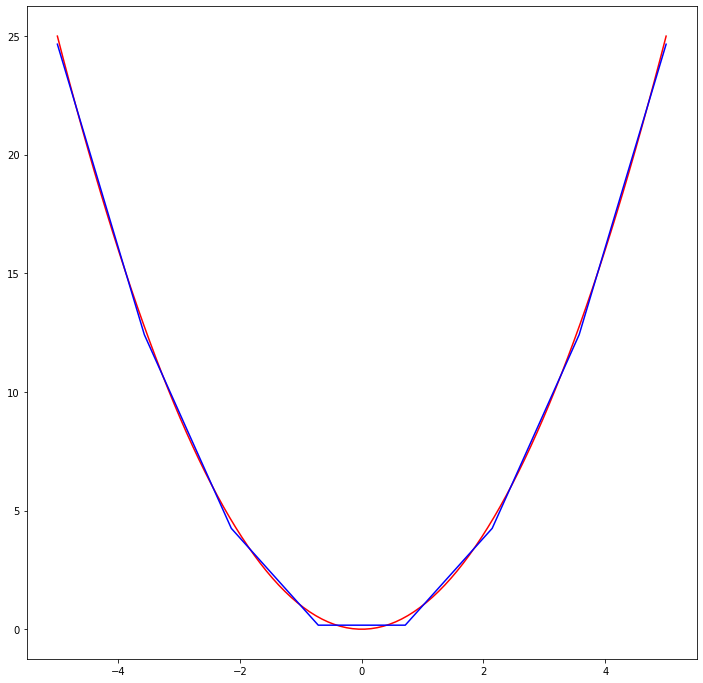


Number of interval :  14

Alphas :  [24.91476404 18.28237243 12.67005747  8.07823951  4.50680591  1.95578685
  0.42517424 -0.08502972  0.42517424  1.95578685  4.50680591  8.07823951
 12.67005747 18.28237243 24.91476404]


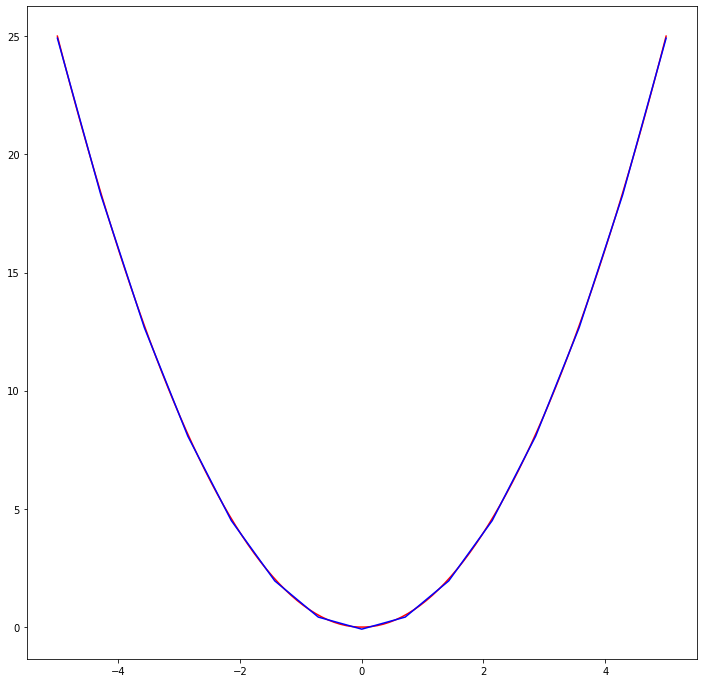


Number of interval :  21

Alphas :  [2.49620715e+01 2.04270984e+01 1.63454191e+01 1.27173137e+01
 9.54270715e+00 6.82161962e+00 4.55404568e+00 2.73998679e+00
 1.37944255e+00 4.72413077e-01 1.88983369e-02 1.88983369e-02
 4.72413077e-01 1.37944255e+00 2.73998679e+00 4.55404568e+00
 6.82161962e+00 9.54270715e+00 1.27173137e+01 1.63454191e+01
 2.04270984e+01 2.49620715e+01]


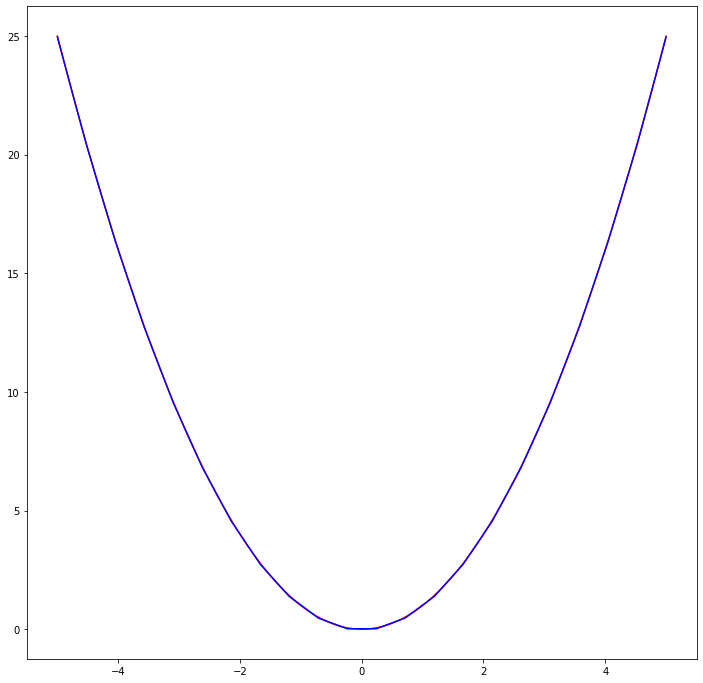


Number of interval :  28

Alphas :  [ 2.49786395e+01  2.15348926e+01  1.83460821e+01  1.54124180e+01
  1.27338441e+01  1.03103754e+01  8.14200783e+00  6.22874257e+00
  4.57057929e+00  3.16751807e+00  2.01955889e+00  1.12670174e+00
  4.88946641e-01  1.06293580e-01 -2.12574405e-02  1.06293580e-01
  4.88946641e-01  1.12670174e+00  2.01955889e+00  3.16751807e+00
  4.57057929e+00  6.22874257e+00  8.14200783e+00  1.03103754e+01
  1.27338441e+01  1.54124180e+01  1.83460821e+01  2.15348926e+01
  2.49786395e+01]


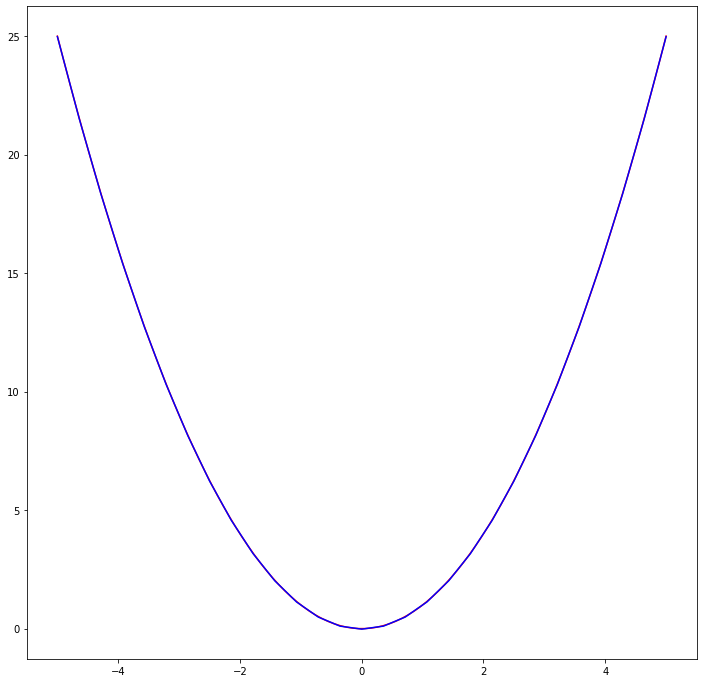

In [118]:
test_L2_projection(square_function, 100)


Number of interval :  7

Alphas :  [ 25.98467793   8.18080537  -4.1632866   -0.61338824   0.61338824
   4.1632866   -8.18080537 -25.98467793]


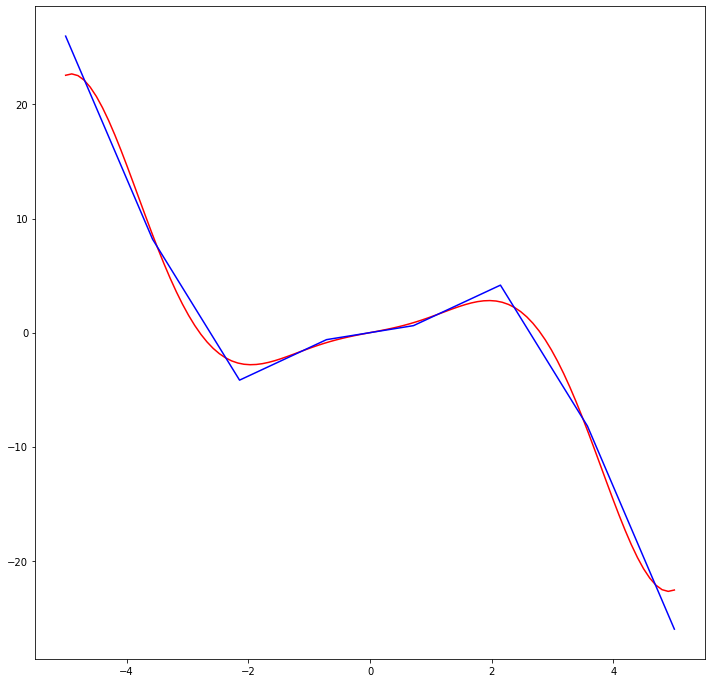


Number of interval :  14

Alphas :  [ 2.36309548e+01  1.90160540e+01  8.35031987e+00 -5.78351147e-03
 -3.01753019e+00 -2.27836818e+00 -8.14006667e-01  6.24715068e-17
  8.14006667e-01  2.27836818e+00  3.01753019e+00  5.78351147e-03
 -8.35031987e+00 -1.90160540e+01 -2.36309548e+01]


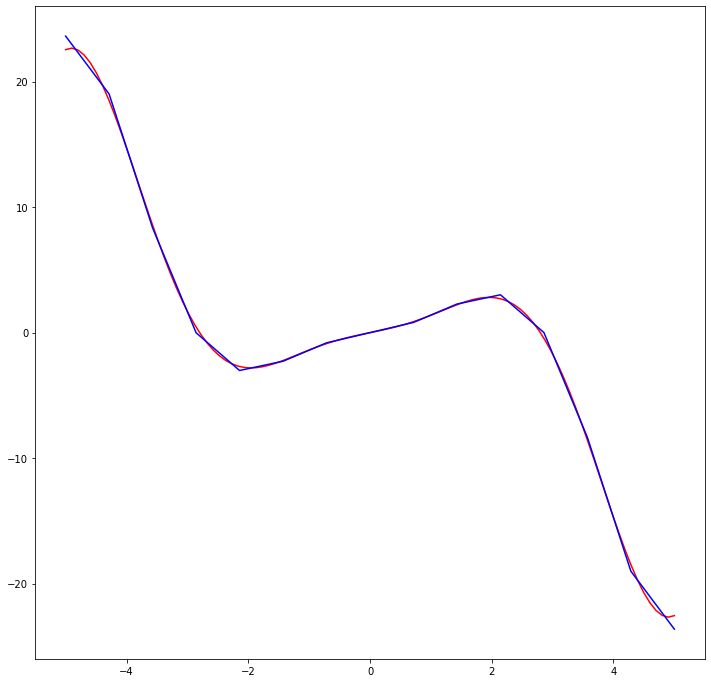


Number of interval :  21

Alphas :  [ 23.05274711  21.29328923  15.48930916   8.47620976   2.46112702
  -1.34932099  -2.84017805  -2.66625613  -1.75648524  -0.84846768
  -0.23141552   0.23141552   0.84846768   1.75648524   2.66625613
   2.84017805   1.34932099  -2.46112702  -8.47620976 -15.48930916
 -21.29328923 -23.05274711]


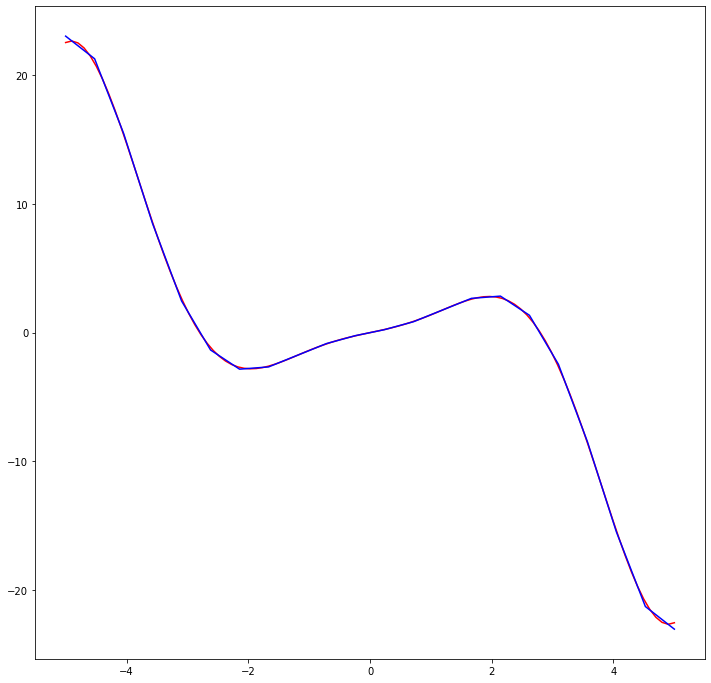


Number of interval :  28

Alphas :  [ 2.28399371e+01  2.20496932e+01  1.86141760e+01  1.37314483e+01
  8.51385711e+00  3.86096629e+00  3.38828503e-01 -1.84178943e+00
 -2.77895264e+00 -2.77975392e+00 -2.23740410e+00 -1.51478533e+00
 -8.59874530e-01 -3.68780403e-01 -1.56178766e-17  3.68780403e-01
  8.59874530e-01  1.51478533e+00  2.23740410e+00  2.77975392e+00
  2.77895264e+00  1.84178943e+00 -3.38828503e-01 -3.86096629e+00
 -8.51385711e+00 -1.37314483e+01 -1.86141760e+01 -2.20496932e+01
 -2.28399371e+01]


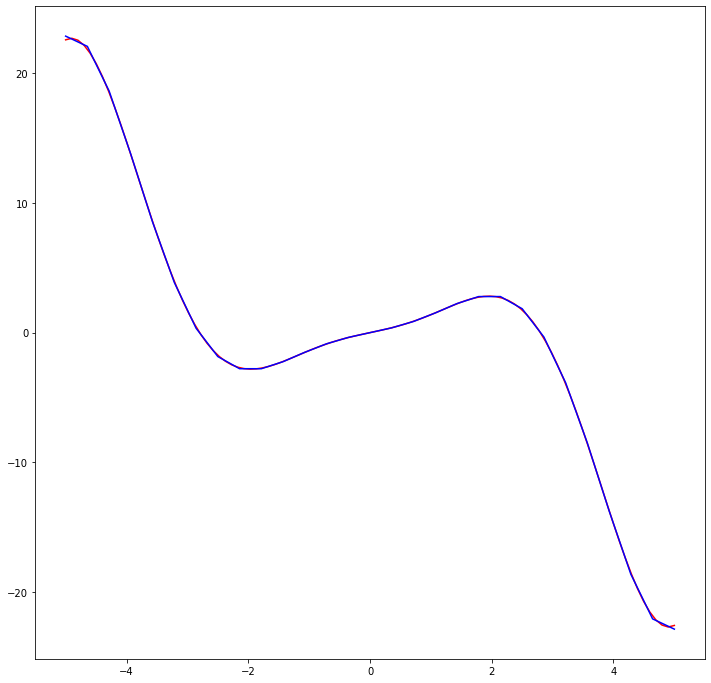

In [119]:
test_L2_projection(complex_function, 100)

# **Discussion**

We see that the result of our algorithm does not give the same as a simple linear interpolant. This is why I chose to use the rectangle method to approximate the different integrales we have to compute, even if the method is clearly not optimized for this kind of usage. More tests could have been interesting to be sure that our algorithm behaves correctly, computing the norm $||f-P_Nf||$ at each iteration for example, but the plots seem already really convincing.